In [1106]:
"""
Some of the animals from the growing Normalizing Flows zoo


Reference:

NICE: Non-linear Independent Components Estimation, Dinh et al. 2014
https://arxiv.org/abs/1410.8516

Variational Inference with Normalizing Flows, Rezende and Mohamed 2015
https://arxiv.org/abs/1505.05770

Density estimation using Real NVP, Dinh et al. May 2016
https://arxiv.org/abs/1605.08803
(Laurent's extension of NICE)

Improved Variational Inference with Inverse Autoregressive Flow, Kingma et al June 2016
https://arxiv.org/abs/1606.04934
(IAF)

Masked Autoregressive Flow for Density Estimation, Papamakarios et al. May 2017 
https://arxiv.org/abs/1705.07057
"The advantage of Real NVP compared to MAF and IAF is that it can both generate data and estimate densities with one forward pass only, whereas MAF would need D passes to generate data and IAF would need D passes to estimate densities."
(MAF)

Glow: Generative Flow with Invertible 1x1 Convolutions, Kingma and Dhariwal, Jul 2018
https://arxiv.org/abs/1807.03039

"Normalizing Flows for Probabilistic Modeling and Inference"
https://arxiv.org/abs/1912.02762
(review paper)

todos
TODO: make work on GPU
TODO: 2D -> ND: get (flat) MNIST to work, reproduce numbers
TODO: ND -> images (multi-scale architectures, Glow nets, etc)
TODO: more stable residual-like IAF-style updates (tried but didn't work too well)
TODO: parallel wavenet
TODO: radial/planar 2D flows from Rezende Mohamed 2015?

from IPython.core.debugger import set_trace; set_trace()
"""

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
from torch import nn
from torch import distributions
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform
from torch.nn.parameter import Parameter

import scipy.linalg

In [1152]:
# Lightweight datasets
import pickle
from sklearn import datasets

class DatasetSIGGRAPH:
    """ 
    haha, found from Eric https://blog.evjang.com/2018/01/nf2.html
    https://github.com/ericjang/normalizing-flows-tutorial/blob/master/siggraph.pkl
    """
    def __init__(self):
        with open('siggraph.pkl', 'rb') as f:
            XY = np.array(pickle.load(f), dtype=np.float32)
            XY -= np.mean(XY, axis=0) # center
        self.XY = torch.from_numpy(XY)
    
    def sample(self, n):
        X = self.XY[np.random.randint(self.XY.shape[0], size=n)]
        return X

class DatasetMoons:
    """ two half-moons """
    def sample(self, n):
        moons = datasets.make_moons(n_samples=n, noise=0.05)[0].astype(np.float32)
        return torch.from_numpy(moons)

class DatasetMixture:
    """ 4 mixture of gaussians """
    def sample(self, n):
        assert n%4 == 0
        r = np.r_[np.random.randn(n // 4, 2)*0.5 + np.array([0, -2]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([0, 0]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([2, 2]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([-2, 2])]
        return torch.from_numpy(r.astype(np.float32))


In [1153]:
# Helper networks

class LeafParam(nn.Module):
    """ 
    just ignores the input and outputs a parameter tensor, lol 
    todo maybe this exists in PyTorch somewhere?
    """
    def __init__(self, n):
        super().__init__()
        self.p = nn.Parameter(torch.Tensor(1,n))
    
    def forward(self, x):
        return self.p.expand(x.size(0), self.p.size(1))


class MLP(nn.Module):
    """ a simple 4-layer MLP """
    def __init__(self, nin, nout, nh):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(nin, nh),
            nn.LeakyReLU(0.2),
            nn.Linear(nh, nh),
            nn.LeakyReLU(0.2),
            nn.Linear(nh, nh),
            nn.LeakyReLU(0.2),
            nn.Linear(nh, nout),
        )
    def forward(self, x):
        return self.net(x)

# MADE nets below are copy pasted from my earlier MADE implementation
# https://github.com/karpathy/pytorch-made

class MaskedLinear(nn.Linear):
    """ same as Linear except has a configurable mask on the weights """
    
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)        
        self.register_buffer('mask', torch.ones(out_features, in_features))
        
    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))
        
    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)

class MADE(nn.Module):
    def __init__(self, nin, hidden_sizes, nout, num_masks=1, natural_ordering=False):
        """
        nin: integer; number of inputs
        hidden sizes: a list of integers; number of units in hidden layers
        nout: integer; number of outputs, which usually collectively parameterize some kind of 1D distribution
              note: if nout is e.g. 2x larger than nin (perhaps the mean and std), then the first nin
              will be all the means and the second nin will be stds. i.e. output dimensions depend on the
              same input dimensions in "chunks" and should be carefully decoded downstream appropriately.
              the output of running the tests for this file makes this a bit more clear with examples.
        num_masks: can be used to train ensemble over orderings/connections
        natural_ordering: force natural ordering of dimensions, don't use random permutations
        """
        
        super().__init__()
        self.nin = nin
        self.nout = nout
        self.hidden_sizes = hidden_sizes
        assert self.nout % self.nin == 0, "nout must be integer multiple of nin"
        
        # define a simple MLP neural net
        self.net = []
        hs = [nin] + hidden_sizes + [nout]
        for h0,h1 in zip(hs, hs[1:]):
            self.net.extend([
                    MaskedLinear(h0, h1),
                    nn.ReLU(),
                ])
        self.net.pop() # pop the last ReLU for the output layer
        self.net = nn.Sequential(*self.net)
        
        # seeds for orders/connectivities of the model ensemble
        self.natural_ordering = natural_ordering
        self.num_masks = num_masks
        self.seed = 0 # for cycling through num_masks orderings
        
        self.m = {}
        self.update_masks() # builds the initial self.m connectivity
        # note, we could also precompute the masks and cache them, but this
        # could get memory expensive for large number of masks.
        
    def update_masks(self):
        if self.m and self.num_masks == 1: return # only a single seed, skip for efficiency
        L = len(self.hidden_sizes)
        
        # fetch the next seed and construct a random stream
        rng = np.random.RandomState(self.seed)
        self.seed = (self.seed + 1) % self.num_masks
        
        # sample the order of the inputs and the connectivity of all neurons
        self.m[-1] = np.arange(self.nin) if self.natural_ordering else rng.permutation(self.nin)
        for l in range(L):
            self.m[l] = rng.randint(self.m[l-1].min(), self.nin-1, size=self.hidden_sizes[l])
        
        # construct the mask matrices
        masks = [self.m[l-1][:,None] <= self.m[l][None,:] for l in range(L)]
        masks.append(self.m[L-1][:,None] < self.m[-1][None,:])
        
        # handle the case where nout = nin * k, for integer k > 1
        if self.nout > self.nin:
            k = int(self.nout / self.nin)
            # replicate the mask across the other outputs
            masks[-1] = np.concatenate([masks[-1]]*k, axis=1)
        
        # set the masks in all MaskedLinear layers
        layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
        for l,m in zip(layers, masks):
            l.set_mask(m)
    
    def forward(self, x):
        return self.net(x)

class ARMLP(nn.Module):
    """ a 4-layer auto-regressive MLP, wrapper around MADE net """
    def __init__(self, nin, nout, nh):
        super().__init__()
        self.net = MADE(nin, [nh, nh, nh], nout, num_masks=1, natural_ordering=True)
        
    def forward(self, x):
        return self.net(x)
    

In [1154]:
# Flows

class AffineConstantFlow(nn.Module):
    """ 
    Scales + Shifts the flow by (learned) constants per dimension.
    In NICE paper there is a Scaling layer which is a special case of this where t is None
    """
    def __init__(self, dim, scale=True, shift=True):
        super().__init__()
        self.s = nn.Parameter(torch.randn(1, dim, requires_grad=True)) if scale else None
        self.t = nn.Parameter(torch.randn(1, dim, requires_grad=True)) if shift else None
        
    def forward(self, x):
        s = self.s if self.s is not None else x.new_zeros(x.size())
        t = self.t if self.t is not None else x.new_zeros(x.size())
        z = x * torch.exp(s) + t
        log_det = torch.sum(s, dim=1)
        return z, log_det
    
    def backward(self, z):
        s = self.s if self.s is not None else z.new_zeros(z.size())
        t = self.t if self.t is not None else z.new_zeros(z.size())
        x = (z - t) * torch.exp(-s)
        log_det = torch.sum(-s, dim=1)
        return x, log_det


class ActNorm(AffineConstantFlow):
    """
    Really an AffineConstantFlow but with a data-dependent initialization,
    where on the very first batch we clever initialize the s,t so that the output
    is unit gaussian. As described in Glow paper.
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data_dep_init_done = False
    
    def forward(self, x):
        # first batch is used for init
        if not self.data_dep_init_done:
            assert self.s is not None and self.t is not None # for now
            self.s.data = (-torch.log(x.std(dim=0, keepdim=True))).detach()
            self.t.data = (-(x * torch.exp(self.s)).mean(dim=0, keepdim=True)).detach()
            self.data_dep_init_done = True
        return super().forward(x)


class AffineHalfFlow(nn.Module):
    """
    As seen in RealNVP, affine autoregressive flow (z = x * exp(s) + t), where half of the 
    dimensions in x are linearly scaled/transfromed as a function of the other half.
    Which half is which is determined by the parity bit.
    - RealNVP both scales and shifts (default)
    - NICE only shifts
    """
    def __init__(self, dim, parity, net_class=MLP, nh=24, scale=True, shift=True):
        super().__init__()
        self.dim = dim
        self.parity = parity
        self.s_cond = lambda x: x.new_zeros(x.size(0), self.dim // 2)
        self.t_cond = lambda x: x.new_zeros(x.size(0), self.dim // 2)
        if scale:
            self.s_cond = net_class(self.dim // 2, self.dim // 2, nh)
        if shift:
            self.t_cond = net_class(self.dim // 2, self.dim // 2, nh)
        
    def forward(self, x):
        x0, x1 = x[:,::2], x[:,1::2]
        if self.parity:
            x0, x1 = x1, x0
        s = self.s_cond(x0)
        t = self.t_cond(x0)
        z0 = x0 # untouched half
        z1 = torch.exp(s) * x1 + t # transform this half as a function of the other
        if self.parity:
            z0, z1 = z1, z0
        z = torch.cat([z0, z1], dim=1)
        log_det = torch.sum(s, dim=1)
        return z, log_det
    
    def backward(self, z):
        z0, z1 = z[:,::2], z[:,1::2]
        if self.parity:
            z0, z1 = z1, z0
        s = self.s_cond(z0)
        t = self.t_cond(z0)
        x0 = z0 # this was the same
        x1 = (z1 - t) * torch.exp(-s) # reverse the transform on this half
        if self.parity:
            x0, x1 = x1, x0
        x = torch.cat([x0, x1], dim=1)
        log_det = torch.sum(-s, dim=1)
        return x, log_det


class SlowMAF(nn.Module):
    """ 
    Masked Autoregressive Flow, slow version with explicit networks per dim
    """
    def __init__(self, dim, parity, net_class=MLP, nh=24):
        super().__init__()
        self.dim = dim
        self.layers = nn.ModuleDict()
        self.layers[str(0)] = LeafParam(2)
        for i in range(1, dim):
            self.layers[str(i)] = MLP(i, 2, nh)
        self.order = list(range(dim)) if parity else list(range(dim))[::-1]
        
    def forward(self, x):
        z = torch.zeros_like(x)
        log_det = torch.zeros(x.size(0))
        for i in range(self.dim):
            st = self.layers[str(i)](x[:, :i])
            s, t = st[:, 0], st[:, 1]
            z[:, self.order[i]] = x[:, i] * torch.exp(s) + t
            log_det += s
        return z, log_det

    def backward(self, z):
        x = torch.zeros_like(z)
        log_det = torch.zeros(z.size(0))
        for i in range(self.dim):
            st = self.layers[str(i)](x[:, :i])
            s, t = st[:, 0], st[:, 1]
            x[:, i] = (z[:, self.order[i]] - t) * torch.exp(-s)
            log_det += -s
        return x, log_det

class MAF(nn.Module):
    """ Masked Autoregressive Flow that uses a MADE-style network for fast forward """
    
    def __init__(self, dim, parity, net_class=ARMLP, nh=24):
        super().__init__()
        self.dim = dim
        self.net = net_class(dim, dim*2, nh)
        self.parity = parity

    def forward(self, x):
        # here we see that we are evaluating all of z in parallel, so density estimation will be fast
        st = self.net(x)
        s, t = st.split(self.dim, dim=1)
        z = x * torch.exp(s) + t
        # reverse order, so if we stack MAFs correct things happen
        z = z.flip(dims=(1,)) if self.parity else z
        log_det = torch.sum(s, dim=1)
        return z, log_det
    
    def backward(self, z):
        # we have to decode the x one at a time, sequentially
        x = torch.zeros_like(z)
        log_det = torch.zeros(z.size(0))
        z = z.flip(dims=(1,)) if self.parity else z
        for i in range(self.dim):
            st = self.net(x.clone()) # clone to avoid in-place op errors if using IAF
            s, t = st.split(self.dim, dim=1)
            x[:, i] = (z[:, i] - t[:, i]) * torch.exp(-s[:, i])
            log_det += -s[:, i]
        return x, log_det

class IAF(MAF):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        """
        reverse the flow, giving an Inverse Autoregressive Flow (IAF) instead, 
        where sampling will be fast but density estimation slow
        """
        self.forward, self.backward = self.backward, self.forward


class Invertible1x1Conv(nn.Module):
    """ 
    As introduced in Glow paper.
    Slight mod from https://github.com/tonyduan/normalizing-flows/blob/master/nf/flows.py
    """
    
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        W, _ = scipy.linalg.qr(np.random.randn(dim, dim))
        P, L, U = scipy.linalg.lu(W)
        self.P = torch.tensor(P, dtype=torch.float)
        self.L = nn.Parameter(torch.tensor(L, dtype=torch.float))
        self.S = nn.Parameter(torch.tensor(np.diag(U), dtype=torch.float))
        self.U = nn.Parameter(torch.triu(torch.tensor(U, dtype=torch.float), diagonal=1))
        self.W_inv = None

    def forward(self, x):
        L = torch.tril(self.L, diagonal=-1) + torch.diag(torch.ones(self.dim))
        U = torch.triu(self.U, diagonal=1)
        z = x @ self.P @ L @ (U + torch.diag(self.S))
        log_det = torch.sum(torch.log(torch.abs(self.S)))
        return z, log_det

    def backward(self, z):
        if self.W_inv is None:
            L = torch.tril(self.L, diagonal=-1) + torch.diag(torch.ones(self.dim))
            U = torch.triu(self.U, diagonal=1)
            W = self.P @ L @ (U + torch.diag(self.S))
            self.W_inv = torch.inverse(W)
        x = z @ self.W_inv
        log_det = -torch.sum(torch.log(torch.abs(self.S)))
        return x, log_det

# ------------------------------------------------------------------------

class NormalizingFlow(nn.Module):
    """ A sequence of Normalizing Flows is a Normalizing Flow """

    def __init__(self, flows):
        super().__init__()
        self.flows = nn.ModuleList(flows)

    def forward(self, x):
        m, _ = x.shape
        log_det = torch.zeros(m)
        zs = [x]
        for flow in self.flows:
            x, ld = flow.forward(x)
            log_det += ld
            zs.append(x)
        return zs, log_det

    def backward(self, z):
        m, _ = z.shape
        log_det = torch.zeros(m)
        xs = [z]
        for flow in self.flows[::-1]:
            z, ld = flow.backward(z)
            log_det += ld
            xs.append(z)
        return xs, log_det

class NormalizingFlowModel(nn.Module):
    """ A Normalizing Flow Model is a (prior, flow) pair """
    
    def __init__(self, prior, flows):
        super().__init__()
        self.prior = prior
        self.flow = NormalizingFlow(flows)
    
    def forward(self, x):
        zs, log_det = self.flow.forward(x)
        prior_logprob = self.prior.log_prob(zs[-1]).view(x.size(0), -1).sum(1)
        return zs, prior_logprob, log_det

    def backward(self, z):
        xs, log_det = self.flow.backward(z)
        return xs, log_det
    
    def sample(self, num_samples):
        z = self.prior.sample((num_samples,))
        xs, _ = self.flow.backward(z)
        return xs


In [1277]:
# construct a model
#prior = MultivariateNormal(torch.zeros(2), torch.eye(2))
prior = TransformedDistribution(Uniform(torch.zeros(2), torch.ones(2)), SigmoidTransform().inv) # Logistic distribution

# RealNVP
flows = [AffineHalfFlow(dim=2, parity=i%2) for i in range(9)]

# NICE
# flows = [AffineHalfFlow(dim=2, parity=i%2, scale=False) for i in range(4)]
# flows.append(AffineConstantFlow(dim=2, shift=False))

# SlowMAF (MAF, but without any parameter sharing for each dimension's scale/shift)
# flows = [SlowMAF(dim=2, parity=i%2) for i in range(4)]

# MAF (with MADE net, so we get very fast density estimation)
#flows = [MAF(dim=2, parity=i%2, nh=32) for i in range(8)]

# IAF (with MADE net, so we get very fast sampling)
# flows = [IAF(dim=2, parity=i%2) for i in range(3)]

#norms = [ActNorm(dim=2) for _ in flows]
#flows = list(itertools.chain(*zip(norms, flows)))

# Glow paper
# flows = [Invertible1x1Conv(dim=2) for i in range(3)]
# norms = [ActNorm(dim=2) for _ in flows]
# couplings = [AffineHalfFlow(dim=2, parity=i%2, nh=32) for i in range(len(flows))]
# flows = list(itertools.chain(*zip(norms, flows, couplings))) # append a coupling layer after each 1x1

# construct the model
model = NormalizingFlowModel(prior, flows)

In [1278]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4) # todo tune WD
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  22914


In [1279]:
#d = DatasetMoons()
d = DatasetMixture()
#d = DatasetSIGGRAPH()

In [1280]:
model.train()
for k in range(1000):
    x = d.sample(128)
    
    zs, prior_logprob, log_det = model(x)
    logprob = prior_logprob + log_det
    loss = -torch.sum(logprob) # NLL

    model.zero_grad()
    loss.backward()
    optimizer.step()

    if k % 100 == 0:
        print(loss.item())


529.9498291015625
403.74786376953125
391.2003479003906
378.959716796875
364.2067565917969
389.9516906738281
384.5024719238281
363.2198181152344
355.0389404296875
360.84686279296875


Text(0.5, 1.0, 'z -> x')

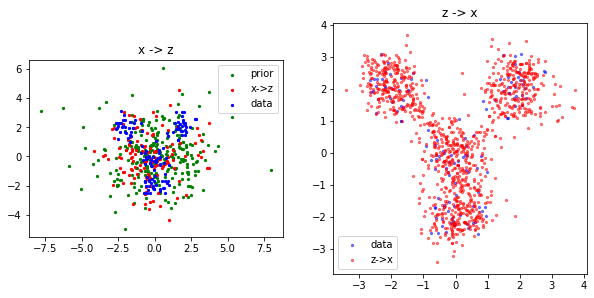

In [1288]:
model.eval()

x = d.sample(128)
zs, prior_logprob, log_det = model(x)
z = zs[-1]

x = x.detach().numpy()
z = z.detach().numpy()
p = model.prior.sample([128, 2]).squeeze()
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(p[:,0], p[:,1], c='g', s=5)
plt.scatter(z[:,0], z[:,1], c='r', s=5)
plt.scatter(x[:,0], x[:,1], c='b', s=5)
plt.legend(['prior', 'x->z', 'data'])
plt.axis('scaled')
plt.title('x -> z')

zs = model.sample(128*8)
z = zs[-1]
z = z.detach().numpy()
plt.subplot(122)
plt.scatter(x[:,0], x[:,1], c='b', s=5, alpha=0.5)
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.5)
plt.legend(['data', 'z->x'])
plt.axis('scaled')
plt.title('z -> x')

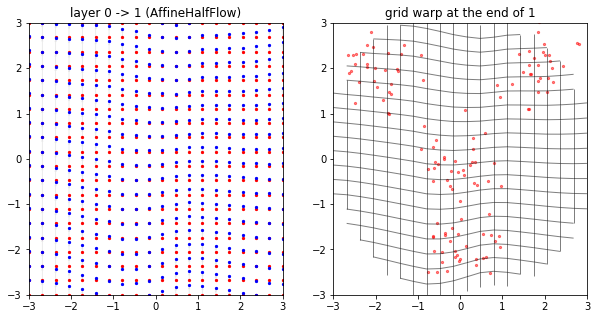

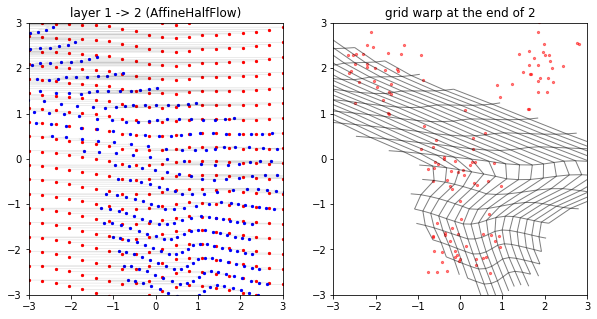

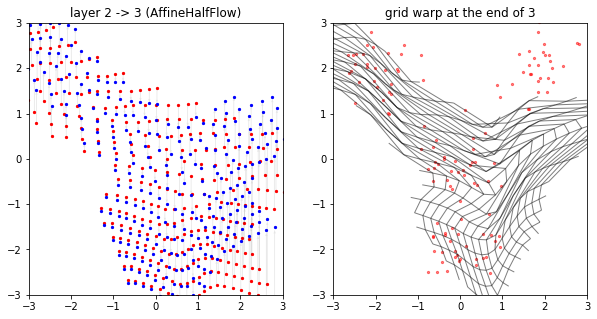

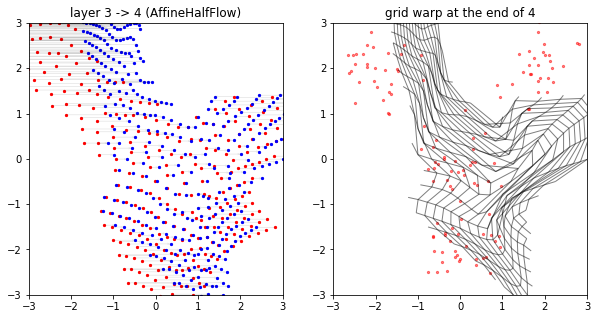

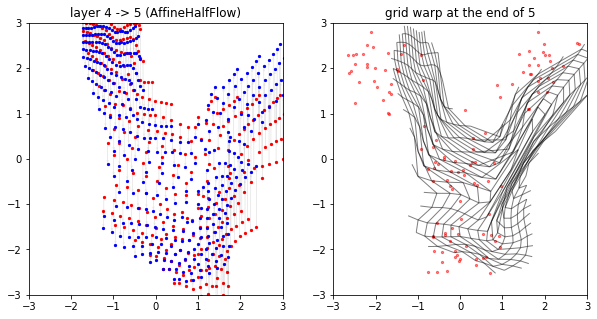

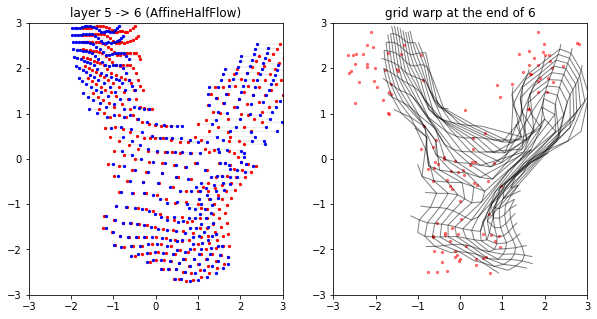

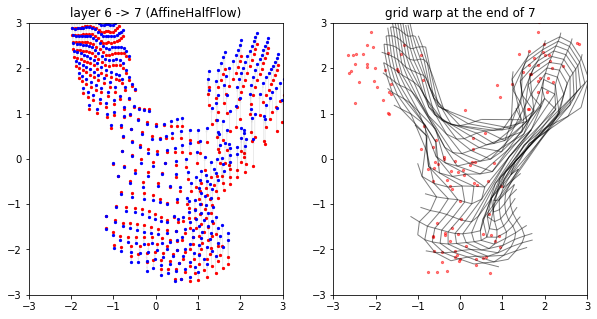

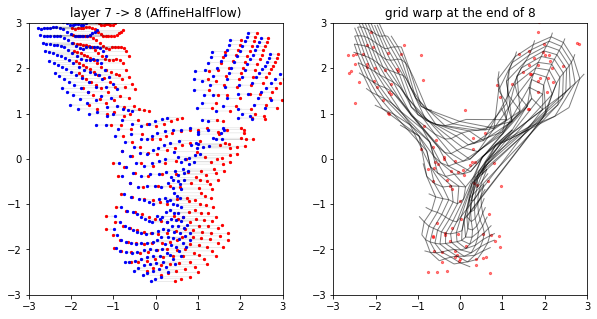

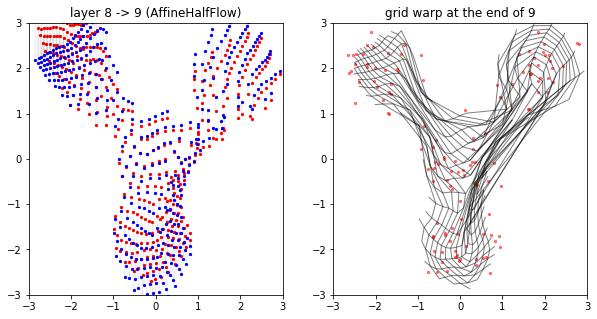

In [1289]:
# Visualize the step-wise flow in the full net
from matplotlib import collections  as mc

# plot the coordinate warp
ng = 20
xx, yy = np.linspace(-3, 3, ng), np.linspace(-3, 3, ng)
xv, yv = np.meshgrid(xx, yy)
xy = np.stack([xv, yv], axis=-1)
in_circle = np.sqrt((xy**2).sum(axis=2)) <= 3 # seems appropriate since we use radial distributions as priors
xy = xy.reshape((ng*ng, 2))
xy = torch.from_numpy(xy.astype(np.float32))

zs, log_det = model.backward(xy)

backward_flow_names = [type(f).__name__ for f in model.flow.flows[::-1]]
nz = len(zs)
for i in range(nz - 1):
    z0 = zs[i].detach().numpy()
    z1 = zs[i+1].detach().numpy()
    
    # plot how the samples travel at this stage
    figs, axs = plt.subplots(1, 2, figsize=(10, 5))
    #plt.figure(figsize=(20,10))
    axs[0].scatter(z0[:,0], z0[:, 1], c='r', s=5)
    axs[0].scatter(z1[:,0], z1[:, 1], c='b', s=5)
    axs[0].quiver(z0[:,0], z0[:,1], z1[:,0] - z0[:,0], z1[:,1] - z0[:,1], units='xy', scale=1, alpha=0.1)
    axs[0].axis([-3, 3, -3, 3])
    axs[0].set_title("layer %d -> %d (%s)" % (i, i+1, backward_flow_names[i]))
    
    q = z1.reshape((ng, ng, 2))
    # y coords
    p1 = np.reshape(q[1:,:,:], (ng**2-ng,2))
    p2 = np.reshape(q[:-1,:,:], (ng**2-ng,2))
    inc = np.reshape(in_circle[1:,:] | in_circle[:-1,:], (ng**2-ng,))
    p1, p2 = p1[inc], p2[inc]
    lcy = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
    # x coords
    p1 = np.reshape(q[:,1:,:], (ng**2-ng,2))
    p2 = np.reshape(q[:,:-1,:], (ng**2-ng,2))
    inc = np.reshape(in_circle[:,1:] | in_circle[:,:-1], (ng**2-ng,))
    p1, p2 = p1[inc], p2[inc]
    lcx = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
    # draw the lines
    axs[1].add_collection(lcy)
    axs[1].add_collection(lcx)
    axs[1].axis([-3, 3, -3, 3])
    axs[1].set_title("grid warp at the end of %d" % (i+1,))
    
    # draw the data too
    plt.scatter(x[:,0], x[:,1], c='r', s=5, alpha=0.5)
    


In [1276]:
# train and render
# code duplication because it's very late at night now and i'm tired

import matplotlib.gridspec as gridspec

ng = 20
xx, yy = np.linspace(-3, 3, ng), np.linspace(-3, 3, ng)
xv, yv = np.meshgrid(xx, yy)
xy = np.stack([xv, yv], axis=-1)
in_circle = np.sqrt((xy**2).sum(axis=2)) <= 3
xy = xy.reshape((ng*ng, 2))
xy = torch.from_numpy(xy.astype(np.float32))

xval = d.sample(128*5)

model.train()
for k in range(500):
    
    # sample
    x = d.sample(128)
    
    # train a bit
    zs, prior_logprob, log_det = model(x)
    logprob = prior_logprob + log_det
    loss = -torch.sum(logprob) # NLL
    model.zero_grad()
    loss.backward()
    optimizer.step()
    
    if k % 10 == 0:
        # vis
        zs, log_det = model.backward(xy)
        backward_flow_names = [type(f).__name__ for f in model.flow.flows[::-1]]
        nz = len(zs)
        i = nz - 1 - 1

        z0 = zs[i].detach().numpy()
        z1 = zs[i+1].detach().numpy()

        # plot how the samples travel at this stage
        ss = 0.1
        fig = plt.figure(figsize=(10, 5))
        outer = gridspec.GridSpec(1, 2, wspace=ss, hspace=ss)
        inner1 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=outer[0], wspace=ss, hspace=ss)
        inner2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[1], wspace=ss, hspace=ss)
        
        backward_flow_names = [type(f).__name__ for f in model.flow.flows[::-1]]
        nz = len(zs)
        for i in range(min(nz-1, 9)):
            ax = plt.Subplot(fig, inner1[i])
            z0 = zs[i].detach().numpy()
            z1 = zs[i+1].detach().numpy()
            ax.scatter(z0[:,0], z0[:, 1], c='r', s=1, alpha=0.5)
            ax.scatter(z1[:,0], z1[:, 1], c='b', s=1, alpha=0.5)
            ax.quiver(z0[:,0], z0[:,1], z1[:,0] - z0[:,0], z1[:,1] - z0[:,1], units='xy', scale=1, alpha=0.5)
            ax.axis([-3, 3, -3, 3])
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            #ax.set_title("layer %d -> %d (%s)" % (i, i+1, backward_flow_names[i]))
            fig.add_subplot(ax)
        
        ax = plt.Subplot(fig, inner2[0])
        q = z1.reshape((ng, ng, 2))
        # y coords
        p1 = np.reshape(q[1:,:,:], (ng**2-ng,2))
        p2 = np.reshape(q[:-1,:,:], (ng**2-ng,2))
        inc = np.reshape(in_circle[1:,:] | in_circle[:-1,:], (ng**2-ng,))
        p1, p2 = p1[inc], p2[inc]
        lcy = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
        # x coords
        p1 = np.reshape(q[:,1:,:], (ng**2-ng,2))
        p2 = np.reshape(q[:,:-1,:], (ng**2-ng,2))
        inc = np.reshape(in_circle[:,1:] | in_circle[:,:-1], (ng**2-ng,))
        p1, p2 = p1[inc], p2[inc]
        lcx = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
        # draw the lines
        ax.add_collection(lcy)
        ax.add_collection(lcx)
        ax.axis([-3, 3, -3, 3])
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        #ax.set_title("grid warp at the end of %d" % (i+1,))
        fig.add_subplot(ax)
        
        # draw the data too
        plt.scatter(xval[:,0], xval[:,1], c='r', s=5, alpha=0.5)
        
        fname = 'out/step_%04d.png' % (k,)
        plt.savefig(fname, dpi=200)
        print("saved", fname, 'loss', loss.item())
        plt.close(fig)
        


saved out/step_0000.png loss 524.7882080078125
saved out/step_0010.png loss 452.5910339355469
saved out/step_0020.png loss 445.9913024902344
saved out/step_0030.png loss 441.19561767578125
saved out/step_0040.png loss 424.9323425292969
saved out/step_0050.png loss 426.89959716796875
saved out/step_0060.png loss 414.24615478515625
saved out/step_0070.png loss 399.5567626953125
saved out/step_0080.png loss 437.666748046875
saved out/step_0090.png loss 404.0690612792969
saved out/step_0100.png loss 397.650390625
saved out/step_0110.png loss 412.2748718261719
saved out/step_0120.png loss 426.6877136230469
saved out/step_0130.png loss 389.20489501953125
saved out/step_0140.png loss 404.6076354980469
saved out/step_0150.png loss 408.2572021484375
saved out/step_0160.png loss 411.3360900878906
saved out/step_0170.png loss 391.0984191894531
saved out/step_0180.png loss 385.4791259765625
saved out/step_0190.png loss 385.4444580078125
saved out/step_0200.png loss 387.2625427246094
saved out/step